In [20]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [21]:
csv_path = "Salary_Data.csv"

In [22]:
df = pd.read_csv(csv_path)
print("Loaded dataset:", csv_path)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print()

Loaded dataset: Salary_Data.csv
Shape: (6704, 6)
Columns: ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']



### Select numeric columns for clustering (auto)

In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found in dataset. Clustering needs numeric features.")

print("Numeric columns used for clustering:", numeric_cols)
X_df = df[numeric_cols].copy().dropna().reset_index(drop=True)
X = X_df.values

Numeric columns used for clustering: ['Age', 'Years of Experience', 'Salary']


### Standardize features for clustering

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-MEANS: evaluate k = 2..10

In [25]:
ks = list(range(2, 11))
inertias = []
silhouettes = []
kmeans_models = {}

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X_scaled, labels)
    except Exception:
        sil = np.nan
    silhouettes.append(sil)
    kmeans_models[k] = km

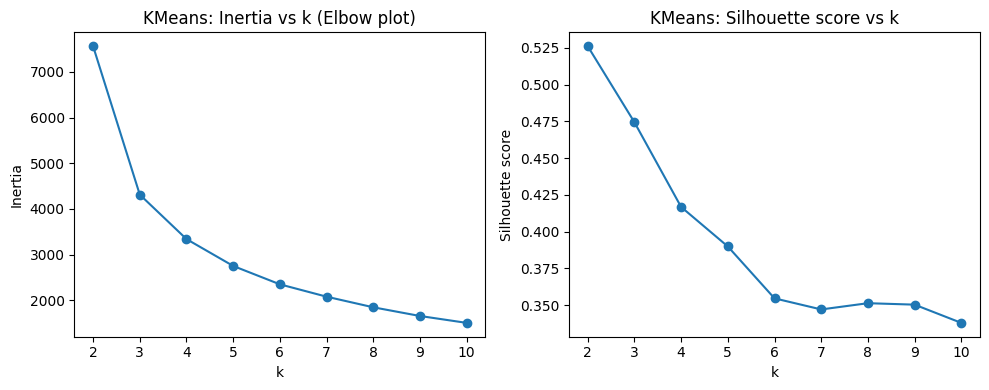

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title("KMeans: Inertia vs k (Elbow plot)")
plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker='o')
plt.title("KMeans: Silhouette score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

In [27]:
# Heuristics for selecting k:
# - Prefer k with maximum silhouette score
valid_sil = [(k, s) for k, s in zip(ks, silhouettes) if (not np.isnan(s))]
if len(valid_sil) > 0:
    best_k_sil = max(valid_sil, key=lambda t: t[1])[0]
else:
    best_k_sil = ks[0]

# - Also compute elbow estimate by largest relative drop in inertia
inertia_diffs = np.diff(inertias)
rel_drops = -inertia_diffs / (np.array(inertias)[:-1] + 1e-12)
elbow_k = ks[int(np.argmax(rel_drops)) + 1]

print(f"KMeans: chosen k by silhouette = {best_k_sil}; elbow (approx) = {elbow_k}")

KMeans: chosen k by silhouette = 2; elbow (approx) = 3


In [28]:
# Use silhouette-based k as final
final_k = best_k_sil
kmeans = kmeans_models[final_k]
labels_km = kmeans.predict(X_scaled)
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)

In [29]:
# Table of cluster centers (original scale) and counts
centers_df = pd.DataFrame(centers_orig, columns=numeric_cols)
centers_df['cluster'] = range(final_k)
counts_km = pd.Series(labels_km).value_counts().sort_index()
counts_df = pd.DataFrame({'cluster': counts_km.index, 'count': counts_km.values}).set_index('cluster')
centers_table = centers_df.set_index('cluster').join(counts_df, how='left').fillna(0).astype(float)
print("\nKMeans cluster centers (original scale) and counts:")
print(centers_table.round(6))


KMeans cluster centers (original scale) and counts:
               Age  Years of Experience         Salary   count
cluster                                                       
0        41.183411            14.330997  167181.511293  2568.0
1        28.921569             4.218470   83092.039700  4131.0


In [30]:
# Cluster radii (Euclidean)
dists = pairwise_distances(X_scaled, centers_scaled, metric='euclidean')
assigned_dists = dists[np.arange(len(labels_km)), labels_km]
radius_info = []
for c in range(final_k):
    mask = (labels_km == c)
    if np.any(mask):
        radius_scaled = float(np.max(assigned_dists[mask]))
        # radius in original units (Euclidean in original feature space)
        radius_orig = float(np.max(np.linalg.norm(X[mask] - centers_orig[c], axis=1)))
    else:
        radius_scaled = 0.0
        radius_orig = 0.0
    radius_info.append({'cluster': c,
                        'radius_euclidean_scaled': radius_scaled,
                        'radius_euclidean_original': radius_orig})
radius_df = pd.DataFrame(radius_info).set_index('cluster')
print("\nKMeans cluster radii (Euclidean): scaled / original-space")
print(radius_df.round(6))


KMeans cluster radii (Euclidean): scaled / original-space
         radius_euclidean_scaled  radius_euclidean_original
cluster                                                    
0                       4.099736              102181.511302
1                       2.138518               98907.960300


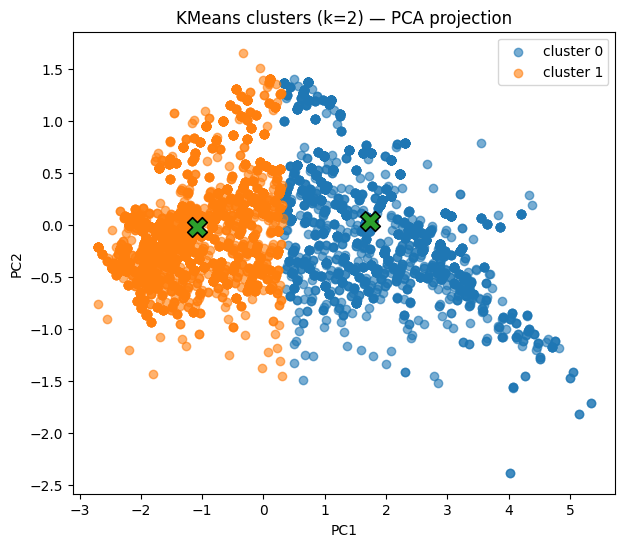

In [31]:
# Visualize clusters using PCA->2D (only for visualization)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(7,6))
for c in range(final_k):
    mask = (labels_km == c)
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'cluster {c}', alpha=0.6)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, edgecolor='k', linewidth=1.2)
plt.title(f'KMeans clusters (k={final_k}) — PCA projection')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.show()

## HIERARCHICAL CLUSTERING

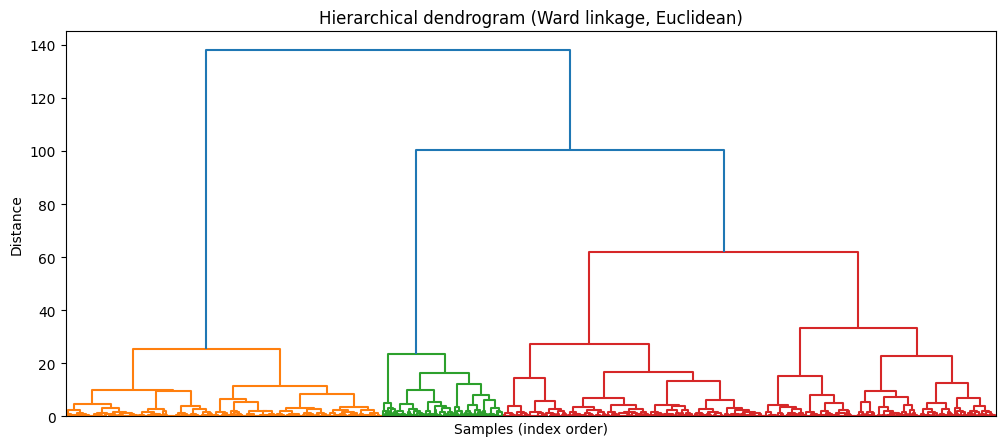

In [32]:
# Use Ward linkage (uses Euclidean distance)
Z = linkage(X_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(12,5))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title("Hierarchical dendrogram (Ward linkage, Euclidean)")
plt.xlabel("Samples (index order)")
plt.ylabel("Distance")
plt.show()

In [33]:
# Determine optimal k for hierarchy: evaluate silhouette for k=2..10
sil_scores_hier = {}
for k in ks:
    labels_h = fcluster(Z, k, criterion='maxclust') - 1  # zero-based
    try:
        sil = silhouette_score(X_scaled, labels_h)
    except Exception:
        sil = np.nan
    sil_scores_hier[k] = sil

valid_h = {k: v for k, v in sil_scores_hier.items() if not np.isnan(v)}
if len(valid_h) > 0:
    best_k_hier = max(valid_h.items(), key=lambda t: t[1])[0]
else:
    best_k_hier = 2

print(f"\nHierarchical clustering: chosen k by silhouette = {best_k_hier}")
print("Silhouette scores by k (hierarchy):")
for k in ks:
    print(f" k={k}: silhouette={sil_scores_hier[k]}")


Hierarchical clustering: chosen k by silhouette = 3
Silhouette scores by k (hierarchy):
 k=2: silhouette=0.40263124220761265
 k=3: silhouette=0.4075572281920504
 k=4: silhouette=0.3882261521710694
 k=5: silhouette=0.3751488574800173
 k=6: silhouette=0.38854123129766766
 k=7: silhouette=0.3369007761668742
 k=8: silhouette=0.33550016573415203
 k=9: silhouette=0.33540110069107215
 k=10: silhouette=0.3177389746231956


In [34]:
# Assign hierarchical clusters
labels_hier = fcluster(Z, best_k_hier, criterion='maxclust') - 1
counts_h = pd.Series(labels_hier).value_counts().sort_index()
counts_h_df = pd.DataFrame({'cluster': counts_h.index, 'count': counts_h.values}).set_index('cluster')
print("\nHierarchical cluster counts:")
print(counts_h_df)


Hierarchical cluster counts:
         count
cluster       
0         2287
1          871
2         3541


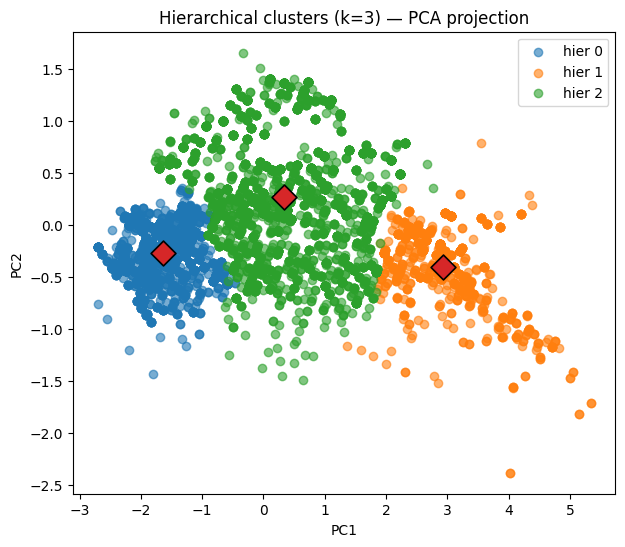

In [35]:
# Compute hierarchical centers (original scale)
centers_hier_orig = []
for c in range(best_k_hier):
    mask = (labels_hier == c)
    if np.any(mask):
        centers_hier_orig.append(X[mask].mean(axis=0))
    else:
        centers_hier_orig.append(np.zeros(X.shape[1]))
centers_hier_orig = np.vstack(centers_hier_orig)
centers_hier_scaled = scaler.transform(centers_hier_orig)
centers_hier_pca = pca.transform(centers_hier_scaled)

plt.figure(figsize=(7,6))
for c in range(best_k_hier):
    mask = (labels_hier == c)
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'hier {c}', alpha=0.6)
plt.scatter(centers_hier_pca[:,0], centers_hier_pca[:,1], marker='D', s=160, edgecolor='k', linewidth=1.2)
plt.title(f'Hierarchical clusters (k={best_k_hier}) — PCA projection')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.show()

## Compare KMeans vs Hierarchical cluster sizes & balance

In [36]:
compare = pd.DataFrame({
    'kmeans_count': counts_km.reindex(range(max(final_k, best_k_hier))).fillna(0).astype(int),
    'hier_count': counts_h.reindex(range(max(final_k, best_k_hier))).fillna(0).astype(int)
}).fillna(0).astype(int)
print("\nComparison of cluster sizes (KMeans vs Hierarchical):")
print(compare)

# Short textual comparison (balance)
def balance_info(series):
    if len(series)==0:
        return "no clusters"
    min_c = series.min(); max_c = series.max(); mean_c = int(series.mean())
    return f"min={min_c}, max={max_c}, mean≈{mean_c}"
print("\nBalance summary:")
print(" KMeans counts:", balance_info(counts_km))
print(" Hierarchical counts:", balance_info(counts_h))


Comparison of cluster sizes (KMeans vs Hierarchical):
   kmeans_count  hier_count
0          2568        2287
1          4131         871
2             0        3541

Balance summary:
 KMeans counts: min=2568, max=4131, mean≈3349
 Hierarchical counts: min=871, max=3541, mean≈2233
